## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [2]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm


import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


We always check that we are running on a GPU

In [2]:
import platform

if torch.cuda.is_available():
    print("The code will run on GPU.")
    device = torch.device('cuda')
elif platform.system() == 'Darwin':
    # For Mac, check for MPS (Apple Silicon GPU support)
    if torch.backends.mps.is_available():
        print("The code will run on Apple Silicon GPU (MPS).")
        device = torch.device('mps')
    else:
        print("The code will run on CPU. MPS not available.")
        device = torch.device('cpu')
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
    device = torch.device('cpu')

The code will run on Apple Silicon GPU (MPS).


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [1]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

NameError: name 'torch' is not defined

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [ ]:
size = 128

train_transform_extra = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.1),  # 10% chance to convert to grayscale
    #transforms.RandomRotation(degrees=15),  # Hotdogs can be rotated
    transforms.ToTensor(),
])

train_transform_default = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform_default)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Let's look at some images from our data 

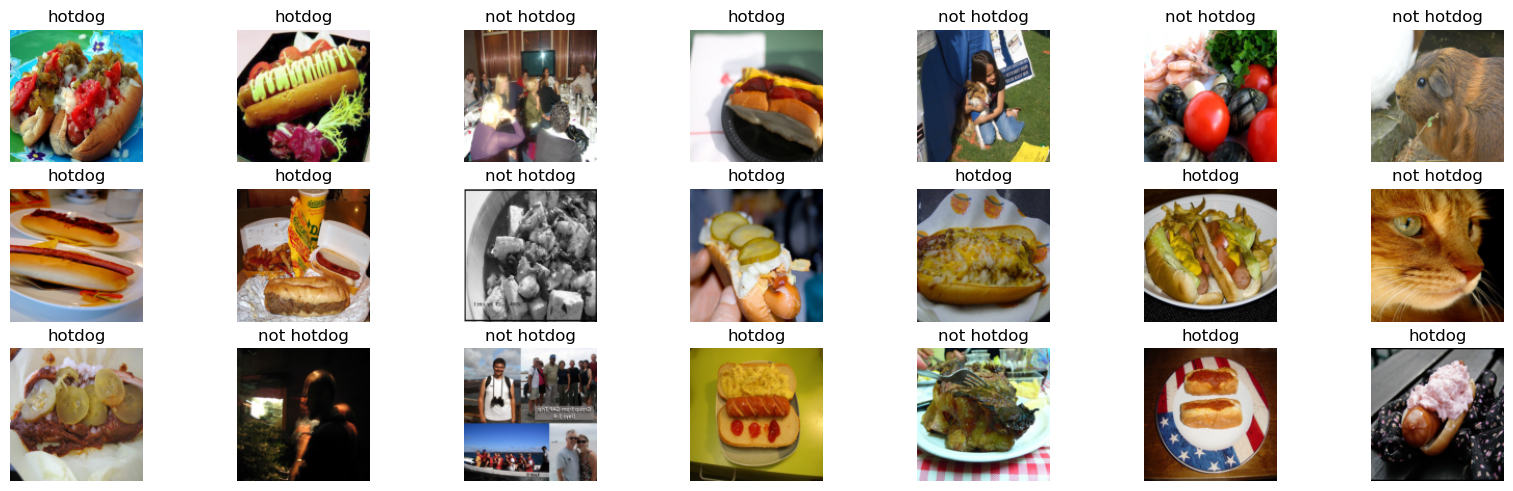

In [5]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


In [6]:
print(f"Training set size: {len(trainset)}")

Training set size: 2047


In [7]:
# Check minimum dimensions of images in the dataset
min_height = float('inf')
min_width = float('inf')
max_height = 0
max_width = 0

print("Analyzing image dimensions...")

# Check training set
for image_path in tqdm(trainset.image_paths, desc="Training images"):
    with Image.open(image_path) as img:
        width, height = img.size
        min_height = min(min_height, height)
        min_width = min(min_width, width)
        max_height = max(max_height, height)
        max_width = max(max_width, width)

# Check test set
for image_path in tqdm(testset.image_paths, desc="Test images"):
    with Image.open(image_path) as img:
        width, height = img.size
        min_height = min(min_height, height)
        min_width = min(min_width, width)
        max_height = max(max_height, height)
        max_width = max(max_width, width)

print(f"\nDataset Image Dimensions Summary:")
print(f"Minimum height: {min_height} pixels")
print(f"Minimum width: {min_width} pixels")
print(f"Maximum height: {max_height} pixels")
print(f"Maximum width: {max_width} pixels")
print(f"Smallest dimension overall: {min(min_height, min_width)} pixels")

Analyzing image dimensions...


Training images:   0%|          | 0/2047 [00:00<?, ?it/s]

Test images:   0%|          | 0/1862 [00:00<?, ?it/s]


Dataset Image Dimensions Summary:
Minimum height: 61 pixels
Minimum width: 61 pixels
Maximum height: 2100 pixels
Maximum width: 3150 pixels
Smallest dimension overall: 61 pixels


Now create a model and train it!


In [ ]:
# Simple CNN Architecture for Small Dataset (2000 images)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        
        # Simple feature extraction - only 3 conv layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)     # 128x128 -> 128x128
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)    # 64x64 -> 64x64  
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)    # 32x32 -> 32x32
        
        self.pool = nn.MaxPool2d(2, 2)  # Halves dimensions each time
        
        # After 3 pooling operations: 128 -> 64 -> 32 -> 16
        # So final feature map is 16x16x64
        self.flatten = nn.Flatten()
        
        # Simple fully connected head
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # 16384 -> 128
        self.fc2 = nn.Linear(128, num_classes)   # 128 -> 2
        
        # Dropout for regularization (important for small datasets)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # Conv block 1
        x = self.pool(F.relu(self.conv1(x)))    # 128x128 -> 64x64
        
        # Conv block 2  
        x = self.pool(F.relu(self.conv2(x)))    # 64x64 -> 32x32
        
        # Conv block 3
        x = self.pool(F.relu(self.conv3(x)))    # 32x32 -> 16x16
        
        # Flatten and fully connected
        x = self.flatten(x)                     # 16x16x64 -> 16384
        x = F.relu(self.fc1(x))                 # 16384 -> 128
        x = self.dropout(x)                     # Dropout for regularization
        x = self.fc2(x)                         # 128 -> 2
        
        return x

# Create simple model
model = SimpleCNN(num_classes=2).to(device)

# Model summary
print("Simple CNN Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Show the dramatic size reduction
print(f"\n📊 Model Comparison:")
print(f"Previous model: ~1.2M parameters")
print(f"This model: {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Reduction: {1200000 / sum(p.numel() for p in model.parameters()):.1f}x smaller! 🎯")

Model Architecture:
HotdogCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    

In [9]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training parameters
num_epochs = 25
best_accuracy = 0.0
train_losses = []
train_accuracies = []
val_accuracies = []

print("Training setup complete!")
print(f"Device: {device}")
print(f"Optimizer: Adam (lr=0.001, weight_decay=1e-4)")
print(f"Scheduler: StepLR (step_size=10, gamma=0.1)")
print(f"Loss function: CrossEntropyLoss")
print(f"Number of epochs: {num_epochs}")

Training setup complete!
Device: mps
Optimizer: Adam (lr=0.001, weight_decay=1e-4)
Scheduler: StepLR (step_size=10, gamma=0.1)
Loss function: CrossEntropyLoss
Number of epochs: 25


In [10]:
# Training and evaluation functions with tqdm
def train_epoch(model, train_loader, criterion, optimizer, device, epoch_num):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Create tqdm progress bar for training
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch_num} [Train]', leave=False)
    
    for batch_idx, (data, target) in enumerate(train_pbar):
        data, target = data.to(device), target.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, target)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        # Update progress bar
        current_acc = 100. * correct / total
        train_pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{current_acc:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def evaluate(model, test_loader, criterion, device, epoch_num):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    # Create tqdm progress bar for validation
    val_pbar = tqdm(test_loader, desc=f'Epoch {epoch_num} [Val]', leave=False)
    
    with torch.no_grad():
        for data, target in val_pbar:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            test_loss += criterion(outputs, target).item()
            
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
            # Update progress bar
            current_acc = 100. * correct / total
            val_pbar.set_postfix({
                'Loss': f'{test_loss/(val_pbar.n+1):.4f}',
                'Acc': f'{current_acc:.2f}%'
            })
    
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

print("Training and evaluation functions with tqdm defined!")

Training and evaluation functions with tqdm defined!


In [11]:
# Main training loop with tqdm
print("Starting training...")
print("=" * 60)

# Create main epoch progress bar
epoch_pbar = tqdm(range(num_epochs), desc="Training Progress")

for epoch in epoch_pbar:
    epoch_num = epoch + 1
    
    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, epoch_num)
    
    # Evaluation phase
    val_loss, val_acc = evaluate(model, test_loader, criterion, device, epoch_num)
    
    # Update learning rate
    scheduler.step()
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    # Update main progress bar
    current_lr = scheduler.get_last_lr()[0]
    epoch_pbar.set_postfix({
        'Train_Acc': f'{train_acc:.1f}%',
        'Val_Acc': f'{val_acc:.1f}%',
        'Best': f'{max(val_accuracies):.1f}%',
        'LR': f'{current_lr:.1e}'
    })
    
    # Save best model
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), 'best_hotdog_model.pth')
        # Print new best model message
        tqdm.write(f'✅ New best model saved! Validation accuracy: {best_accuracy:.2f}%')
    
    # Print detailed epoch summary every 5 epochs
    if epoch_num % 5 == 0 or epoch_num == 1:
        tqdm.write(f'\n📊 Epoch {epoch_num}/{num_epochs} Summary:')
        tqdm.write(f'   Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        tqdm.write(f'   Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        tqdm.write(f'   Learning Rate: {current_lr:.6f}')

epoch_pbar.close()

print("\n" + "=" * 60)
print("🎉 Training completed!")
print(f"🏆 Best validation accuracy: {best_accuracy:.2f}%")

Starting training...


Training Progress:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

✅ New best model saved! Validation accuracy: 54.30%

📊 Epoch 1/25 Summary:
   Train Loss: 0.6081, Train Acc: 67.27%
   Val Loss: 0.7397, Val Acc: 54.30%
   Learning Rate: 0.001000


Epoch 2 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

✅ New best model saved! Validation accuracy: 67.78%


Epoch 3 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 4 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

✅ New best model saved! Validation accuracy: 75.19%


Epoch 5 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]


📊 Epoch 5/25 Summary:
   Train Loss: 0.4826, Train Acc: 77.33%
   Val Loss: 0.6226, Val Acc: 70.62%
   Learning Rate: 0.001000


Epoch 6 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 7 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

✅ New best model saved! Validation accuracy: 76.48%


Epoch 8 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 9 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

✅ New best model saved! Validation accuracy: 77.71%


Epoch 10 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]


📊 Epoch 10/25 Summary:
   Train Loss: 0.4301, Train Acc: 80.80%
   Val Loss: 0.4819, Val Acc: 76.37%
   Learning Rate: 0.000100


Epoch 11 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

✅ New best model saved! Validation accuracy: 78.95%


Epoch 12 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

✅ New best model saved! Validation accuracy: 79.86%


Epoch 13 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

✅ New best model saved! Validation accuracy: 80.56%


Epoch 14 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 15 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

✅ New best model saved! Validation accuracy: 80.61%

📊 Epoch 15/25 Summary:
   Train Loss: 0.3808, Train Acc: 81.78%
   Val Loss: 0.4308, Val Acc: 80.61%
   Learning Rate: 0.000100


Epoch 16 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 17 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 18 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

✅ New best model saved! Validation accuracy: 81.20%


Epoch 19 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 20 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

✅ New best model saved! Validation accuracy: 81.26%

📊 Epoch 20/25 Summary:
   Train Loss: 0.3692, Train Acc: 83.49%
   Val Loss: 0.4363, Val Acc: 81.26%
   Learning Rate: 0.000010


Epoch 21 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 21 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 22 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 22 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 23 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 23 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 24 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 24 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]

✅ New best model saved! Validation accuracy: 81.74%


Epoch 25 [Train]:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 25 [Val]:   0%|          | 0/30 [00:00<?, ?it/s]


📊 Epoch 25/25 Summary:
   Train Loss: 0.3536, Train Acc: 84.66%
   Val Loss: 0.4277, Val Acc: 81.26%
   Learning Rate: 0.000010

🎉 Training completed!
🏆 Best validation accuracy: 81.74%


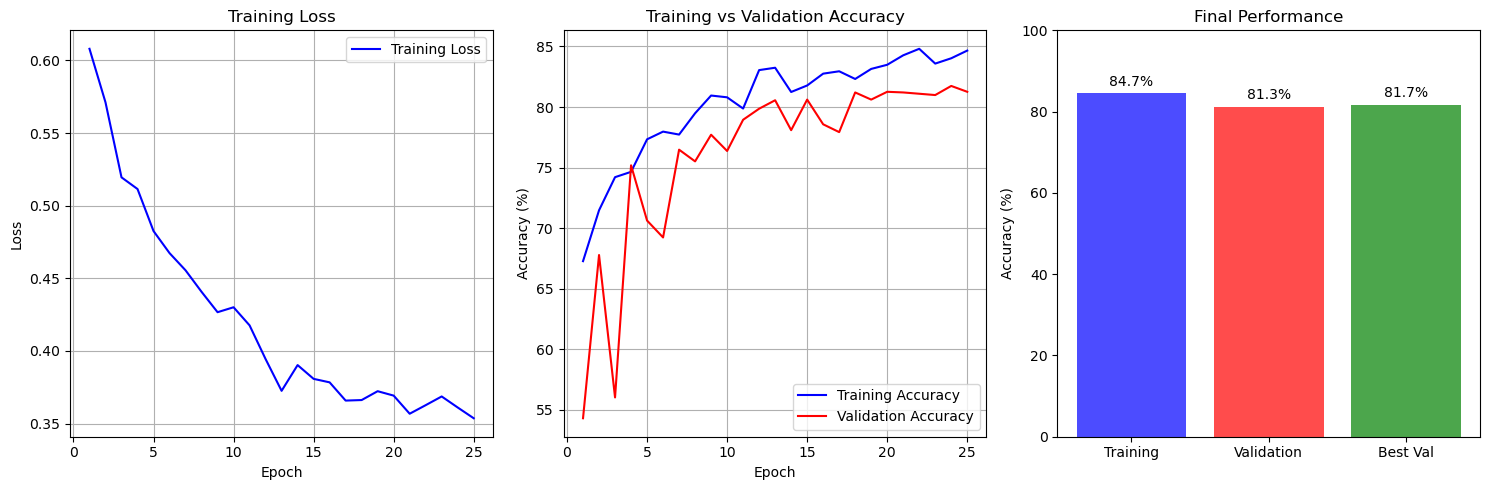


FINAL TRAINING SUMMARY
Final Training Accuracy: 84.66%
Final Validation Accuracy: 81.26%
Best Validation Accuracy: 81.74%
Total Training Epochs: 25


In [13]:
# Plot training results
plt.figure(figsize=(15, 5))

# Plot 1: Training Loss
plt.subplot(1, 3, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Training vs Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'b-', label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Plot 3: Final performance summary
plt.subplot(1, 3, 3)
final_train_acc = train_accuracies[-1] if train_accuracies else 0
final_val_acc = val_accuracies[-1] if val_accuracies else 0
categories = ['Training', 'Validation', 'Best Val']
accuracies = [final_train_acc, final_val_acc, best_accuracy]
colors = ['blue', 'red', 'green']

bars = plt.bar(categories, accuracies, color=colors, alpha=0.7)
plt.title('Final Performance')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{acc:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print final summary
print("\n" + "=" * 50)
print("FINAL TRAINING SUMMARY")
print("=" * 50)
print(f"Final Training Accuracy: {final_train_acc:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc:.2f}%")
print(f"Best Validation Accuracy: {best_accuracy:.2f}%")
print(f"Total Training Epochs: {len(train_accuracies)}")
print("=" * 50)